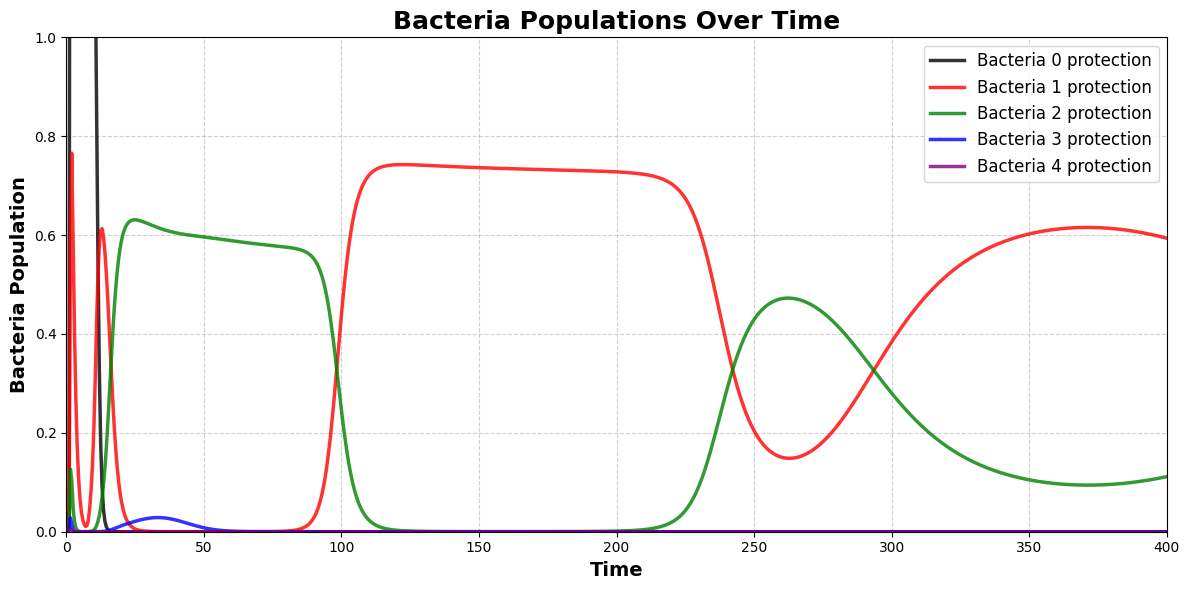

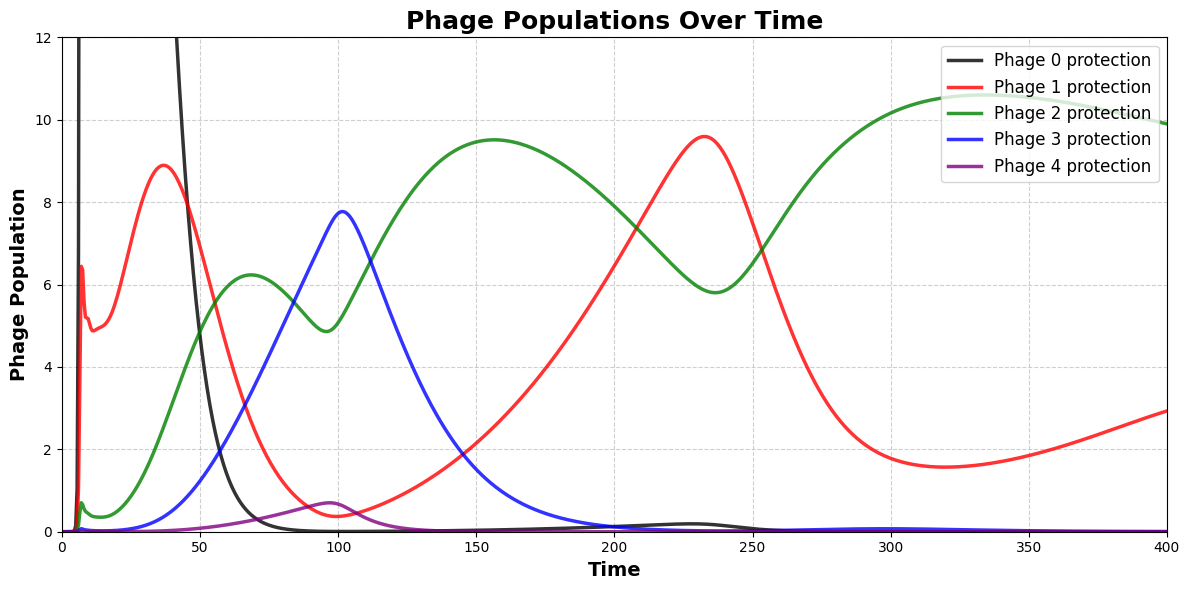

In [ ]:
# Bacteria-Phage Interaction Model with Protection Layers (Optimized Version)
# This model simulates the interaction between bacteria and phages over time,
# considering various protection layers for the bacteria and countermeasures for the phages.


# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

# Parameter Definitions
beta0 = 10          # Maximum growth rate for bacteria
C_beta = 0.1        # Coefficient adjusting bacterial growth rate based on protection layers
K = 1               # Environmental carrying capacity for bacteria
alpha0 = 0.1        # Base attack rate by phages on bacteria
C_alpha = 0.3       # Coefficient adjusting attack rate based on bacterial protection
chi0 = 5            # Maximum growth rate for phages
C_chi = 0.1         # Coefficient adjusting phage growth rate based on countermeasures
delta = 1           # Mortality rate of phages
Bseed = 2e-6        # Initial bacterial population
Pseed = 2e-6        # Initial phage population

# Maximum number of protection layers
max_layers = 4

# Function to generate all possible combinations of protection layers for bacteria and countermeasures for phages
def generate_combinations(max_layers):
    """
    Generates all possible combinations of protection layers for bacteria and countermeasures for phages.

    Args:
    max_layers (int): Maximum number of layers to consider.

    Returns:
    combinations (list of lists): All possible combinations of protection layers.
    """
    combinations = []
    for i in range(1 << max_layers):
        comb = [j + 1 for j in range(max_layers) if (i & (1 << j))]
        combinations.append(comb)
    return combinations

# Generate bacterial and phage combinations
bacterial_combinations = generate_combinations(max_layers)
phage_combinations = generate_combinations(max_layers)

# Functions for calculating parameters
def beta_i(layers):
    """
    Calculates the growth rate of bacteria considering the protection layers.

    Args:
    layers (list): List of protection layers for the bacterial strain.

    Returns:
    float: Adjusted bacterial growth rate.
    """
    return beta0 * (1 - C_beta * len(layers))

def chi_j(layers):
    """
    Calculates the growth rate of phages considering the countermeasures.

    Args:
    layers (list): List of countermeasures for the phage strain.

    Returns:
    float: Adjusted phage growth rate.
    """
    return chi0 * (1 - C_chi * len(layers))

def alpha_ij(b_layers, p_layers):
    """
    Calculates the attack rate between a bacterial strain and a phage strain,
    adjusting for their protection and countermeasures.

    Args:
    b_layers (list): Protection layers of the bacterial strain.
    p_layers (list): Countermeasures of the phage strain.

    Returns:
    float: Attack rate between the bacterial and phage strains.
    """
    return alpha0 * (1 - C_alpha)**(len(set(b_layers) - set(p_layers)))

# Define the system of ODEs for bacterial and phage population dynamics
def equations(y, t, bacterial_combinations, phage_combinations):
    """
    Defines the ODE system for the interaction between bacteria and phages.

    Args:
    y (array): Current populations of bacteria and phages.
    t (array): Array of time points.
    bacterial_combinations (list): List of bacterial protection combinations.
    phage_combinations (list): List of phage countermeasure combinations.

    Returns:
    array: Derivatives of bacterial and phage populations.
    """
    num_bacterial_strains = len(bacterial_combinations)
    num_phage_strains = len(phage_combinations)

    B = y[:num_bacterial_strains]  # Bacterial population
    P = y[num_bacterial_strains:]  # Phage population

    dBdt = np.zeros(num_bacterial_strains)  # Derivative of bacterial population
    dPdt = np.zeros(num_phage_strains)     # Derivative of phage population

    # Bacterial population dynamics, affected by protection layers and phage attacks
    for i in range(num_bacterial_strains):
        dBdt[i] = B[i] * (beta_i(bacterial_combinations[i]) - np.sum(B) / K -
                          np.sum([alpha_ij(bacterial_combinations[i], phage_combinations[j]) * P[j]
                                  for j in range(num_phage_strains)]))

    # Phage population dynamics, affected by countermeasures and bacterial population
    for j in range(num_phage_strains):
        dPdt[j] = P[j] * (chi_j(phage_combinations[j]) * np.sum([alpha_ij(bacterial_combinations[i],
                                                                            phage_combinations[j]) * B[i]
                                                                for i in range(num_bacterial_strains)]) - delta)

    return np.concatenate((dBdt, dPdt))

# Initial conditions for bacterial and phage populations
num_bacterial_strains = len(bacterial_combinations)
num_phage_strains = len(phage_combinations)

B0 = np.full(num_bacterial_strains, Bseed)  # Initial bacterial population
P0 = np.full(num_phage_strains, Pseed)      # Initial phage population
y0 = np.concatenate((B0, P0))               # Combine initial populations

# Time points for simulation (up to 800)
t = np.linspace(0, 400, 800)

# Solve the system of ODEs using odeint
solution = odeint(equations, y0, t, args=(bacterial_combinations, phage_combinations))

# Set up color mapping and line styles
color_mapping = {
    0: 'black',      # No protection
    1: 'red',        # 1 protection layer
    2: 'green',      # 2 protection layers
    3: 'blue',       # 3 protection layers
    4: 'purple'      # 4 protection layers
}
linestyles = ['-']  # Use solid line style

# Choose one representative from each protection class for plotting
unique_representatives = {
    0: next(i for i in range(num_bacterial_strains) if len(bacterial_combinations[i]) == 0),
    1: next(i for i in range(num_bacterial_strains) if len(bacterial_combinations[i]) == 1),
    2: next(i for i in range(num_bacterial_strains) if len(bacterial_combinations[i]) == 2),
    3: next(i for i in range(num_bacterial_strains) if len(bacterial_combinations[i]) == 3),
    4: next(i for i in range(num_bacterial_strains) if len(bacterial_combinations[i]) == 4),
}

# Plot Bacteria Populations Over Time
plt.figure(figsize=(12, 6))
for protection_level, i in unique_representatives.items():
    plt.plot(t, solution[:, i], linestyle=linestyles[0],
             color=color_mapping[protection_level], alpha=0.8, linewidth=2.5,
             label=f'Bacteria {len(bacterial_combinations[i])} protection')

plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Bacteria Population', fontsize=14, fontweight='bold')
plt.ylim(0, 1)  # Y-axis limits for bacteria
plt.xlim(0, 400)  # X-axis limits for time
plt.title('Bacteria Populations Over Time', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)  # Display legend
plt.tight_layout()
plt.show()

# Plot Phage Populations Over Time
plt.figure(figsize=(12, 6))
for protection_level, j in unique_representatives.items():
    plt.plot(t, solution[:, num_bacterial_strains + j], linestyle=linestyles[0],
             color=color_mapping[protection_level], alpha=0.8, linewidth=2.5,
             label=f'Phage {len(phage_combinations[j])} protection')

plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Phage Population', fontsize=14, fontweight='bold')
plt.ylim(0, 12)  # Y-axis limits for phages
plt.xlim(0, 400)  # X-axis limits for time
plt.title('Phage Populations Over Time', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)  # Display legend
plt.tight_layout()
plt.show()


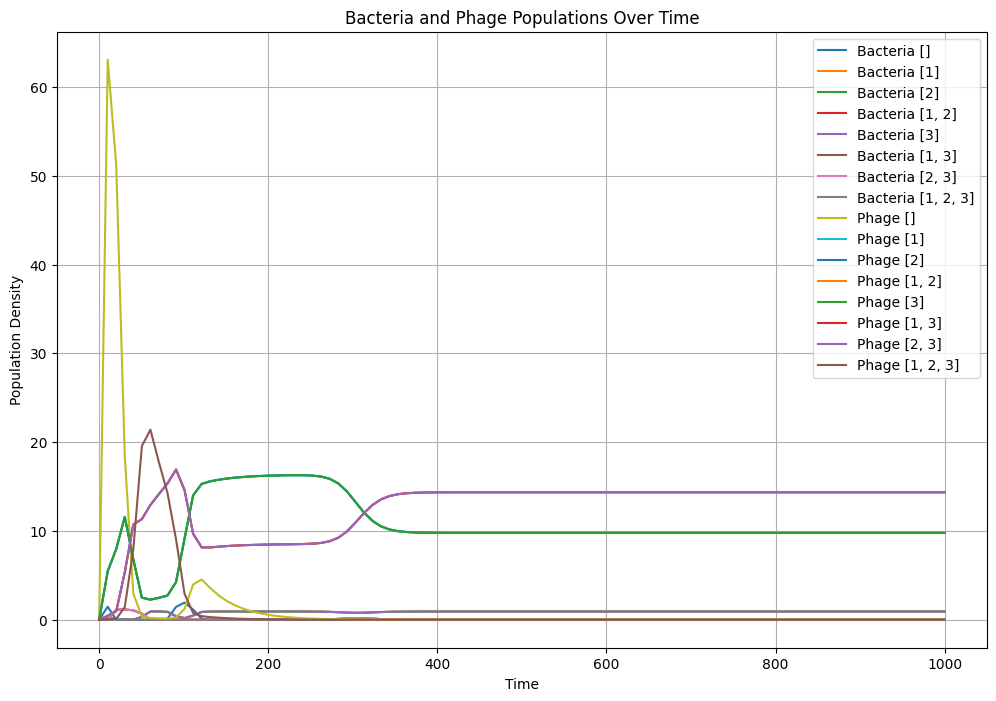

In [ ]:
# Description:
# This code models the dynamics of bacterial and phage populations using a system of ordinary differential equations (ODEs).
# The population densities of both bacteria and phages evolve over time based on various factors like growth rates, attack rates,
# and environmental capacity. The model also includes the interaction between bacteria and phages, and it incorporates layers of defense mechanisms for the bacteria and countermeasures for the phages.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Model parameters
beta0 = 10          # Maximum growth rate for bacteria
C_beta = 0.1        # Coefficient controlling the growth rate reduction with defense layers
K = 1               # Environmental carrying capacity for bacteria
alpha0 = 0.1        # Maximum attack rate of phages on bacteria
C_alpha = 0.3       # Coefficient for phage attack reduction due to defense layers
chi0 = 5            # Maximum phage growth rate
C_chi = 0.1         # Coefficient controlling phage growth reduction with defense layers
delta = 1           # Phage mortality rate
Bseed = 2e-6        # Initial bacterial population
Pseed = 2e-6        # Initial phage population

# Maximum number of defense layers for bacteria and countermeasures for phages
max_layers = 3

# Generate all possible combinations of defense layers for bacteria and countermeasures for phages
def generate_combinations(max_layers):
    """
    Generate all possible combinations of defense layers and countermeasures.

    Parameters:
    - max_layers: The maximum number of layers of defense or countermeasures

    Returns:
    - combinations: A list of all possible combinations (each combination is a list of layer indices)
    """
    combinations = []
    for i in range(1 << max_layers):  # Loop over all bitmasks for layers
        comb = [j + 1 for j in range(max_layers) if (i & (1 << j))]
        combinations.append(comb)
    return combinations

# Get bacterial and phage defense combinations
bacterial_combinations = generate_combinations(max_layers)
phage_combinations = generate_combinations(max_layers)

# Heaviside step function to simulate switching behaviors (e.g., presence or absence of defense layers)
def theta(x):
    """
    Heaviside step function.

    Parameters:
    - x: Input value

    Returns:
    - 1 if x >= 0, else 0
    """
    return 1 if x >= 0 else 0

# Functions to calculate various parameters based on defense layers
def beta_i(layers):
    """
    Calculate the growth rate for a given bacterial defense combination.

    Parameters:
    - layers: The set of defense layers for the bacteria

    Returns:
    - The adjusted growth rate for bacteria
    """
    return beta0 * (1 - C_beta * len(layers))

def chi_j(layers):
    """
    Calculate the growth rate for phages based on their defense combination.

    Parameters:
    - layers: The set of defense layers for the phages

    Returns:
    - The adjusted growth rate for phages
    """
    return chi0 * (1 - C_chi * len(layers))

def alpha_ij(b_layers, p_layers):
    """
    Calculate the attack rate of phages on bacteria, considering both bacterial defense layers
    and phage countermeasures.

    Parameters:
    - b_layers: Defense layers of the bacteria
    - p_layers: Defense countermeasures of the phages

    Returns:
    - The adjusted attack rate
    """
    return alpha0 * (1 - C_alpha)**(len(set(b_layers) - set(p_layers)))

# Define the system of differential equations that model the dynamics
def equations(y, t, bacterial_combinations, phage_combinations):
    """
    Defines the system of ODEs for bacterial and phage population dynamics.

    Parameters:
    - y: The current populations of bacteria and phages
    - t: The current time (not used in equations, but necessary for ODE solver)
    - bacterial_combinations: The list of bacterial defense combinations
    - phage_combinations: The list of phage countermeasure combinations

    Returns:
    - The rates of change for bacteria and phages
    """
    num_bacterial_strains = len(bacterial_combinations)
    num_phage_strains = len(phage_combinations)

    # Extract current bacterial and phage populations from the solution vector
    B = y[:num_bacterial_strains]
    P = y[num_bacterial_strains:]

    # Initialize the rates of change
    dBdt = np.zeros(num_bacterial_strains)
    dPdt = np.zeros(num_phage_strains)

    # Rate of change for bacterial populations
    for i in range(num_bacterial_strains):
        dBdt[i] = B[i] * (
            beta_i(bacterial_combinations[i]) - np.sum(B) / K -
            np.sum([alpha_ij(bacterial_combinations[i], phage_combinations[j]) * P[j] for j in range(num_phage_strains)])
        )

    # Rate of change for phage populations
    for j in range(num_phage_strains):
        dPdt[j] = P[j] * (
            chi_j(phage_combinations[j]) * np.sum([alpha_ij(bacterial_combinations[i], phage_combinations[j]) * B[i] for i in range(num_bacterial_strains)]) - delta
        )

    return np.concatenate((dBdt, dPdt))

# Initial conditions (initial populations of bacteria and phages)
num_bacterial_strains = len(bacterial_combinations)
num_phage_strains = len(phage_combinations)

B0 = np.full(num_bacterial_strains, Bseed)  # Initial bacterial population
P0 = np.full(num_phage_strains, Pseed)      # Initial phage population
y0 = np.concatenate((B0, P0))               # Combine initial populations

# Time vector (from 0 to 1000, 100 time steps)
t = np.linspace(0, 1000, 100)

# Solve the system of ODEs
solution = odeint(equations, y0, t, args=(bacterial_combinations, phage_combinations))

# Visualization of the results
plt.figure(figsize=(12, 8))

# Plot bacterial populations
for i in range(num_bacterial_strains):
    plt.plot(t, solution[:, i], label=f'Bacteria {bacterial_combinations[i]}')

# Plot phage populations
for j in range(num_phage_strains):
    plt.plot(t, solution[:, num_bacterial_strains + j], label=f'Phage {phage_combinations[j]}')

# Labeling the plot
plt.xlabel('Time')
plt.ylabel('Population Density')
plt.title('Bacteria and Phage Populations Over Time')
plt.legend()
plt.grid(True)
plt.show()


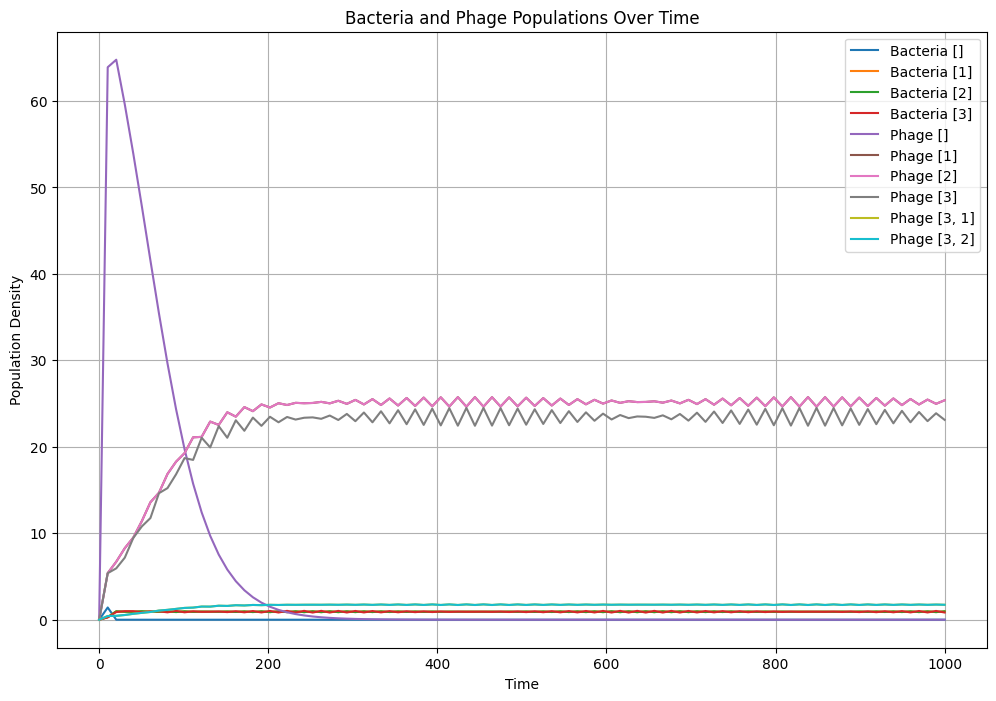

In [ ]:
# Description:
# This simulation models the dynamics of bacterial and phage populations using a system of ODEs.
# The model includes the possibility of mutations in both bacterial and phage strains,
# where bacteria can evolve by acquiring new defense layers, and phages can evolve by acquiring new countermeasures.
# The populations of bacteria and phages evolve over time based on growth rates, interaction dynamics, and mutation processes.
# The simulation also incorporates an extinction threshold for species with low population densities.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Model parameters
beta0 = 10          # Maximum growth rate of bacteria
C_beta = 0.1        # Coefficient for growth rate reduction due to bacterial defense layers
K = 1               # Environmental carrying capacity for bacteria
alpha0 = 0.1        # Maximum attack rate of phages on bacteria
C_alpha = 0.3       # Coefficient for attack rate reduction due to bacterial defense layers
chi0 = 5            # Maximum growth rate of phages
C_chi = 0.1         # Coefficient for phage growth rate reduction due to phage countermeasures
delta = 1           # Phage mortality rate
Bseed = 2e-6        # Initial bacterial population density
Pseed = 2e-6        # Initial phage population density
mutation_frequency = 50  # How often to check for mutations (in terms of time steps)
extinction_threshold = 1e-6  # Threshold below which species are considered extinct

# Maximum number of defense layers for bacteria and countermeasures for phages
max_layers = 3

# Generate all possible combinations of defense layers for bacteria and countermeasures for phages
def generate_combinations(max_layers):
    """
    Generate all possible combinations of defense layers for bacteria or countermeasures for phages.

    Parameters:
    - max_layers: The maximum number of layers (defense or countermeasure).

    Returns:
    - combinations: List of all possible layer combinations.
    """
    combinations = []
    for i in range(1 << max_layers):  # Loop through all possible bitmasks for layers
        comb = [j + 1 for j in range(max_layers) if (i & (1 << j))]
        combinations.append(comb)
    return combinations

# Generate mutants by adding new defense layers for bacteria and countermeasures for phages
def generate_mutants(current_layers, max_layers):
    """
    Generate new mutants by adding additional defense layers or countermeasures.

    Parameters:
    - current_layers: The current layers of defense or countermeasures.
    - max_layers: The maximum number of layers.

    Returns:
    - mutants: A list of new mutant layer combinations.
    """
    mutants = []
    for i in range(1, max_layers + 1):
        if i not in current_layers:
            new_layers = current_layers + [i]
            mutants.append(new_layers)
    return mutants

# Initialize bacterial and phage combinations
bacterial_combinations = generate_combinations(max_layers)
phage_combinations = generate_combinations(max_layers)

# Heaviside step function (not used here, but could be used for conditional switches)
def theta(x):
    """
    Heaviside step function to simulate a threshold behavior.

    Parameters:
    - x: Input value.

    Returns:
    - 1 if x >= 0, otherwise 0.
    """
    return 1 if x >= 0 else 0

# Functions to calculate model parameters based on defense and countermeasure layers
def beta_i(layers):
    """
    Calculate the growth rate for a bacterial strain with a given set of defense layers.

    Parameters:
    - layers: The list of bacterial defense layers.

    Returns:
    - The adjusted growth rate for bacteria.
    """
    return beta0 * (1 - C_beta * len(layers))

def chi_j(layers):
    """
    Calculate the growth rate for phages with a given set of countermeasures.

    Parameters:
    - layers: The list of phage countermeasures.

    Returns:
    - The adjusted growth rate for phages.
    """
    return chi0 * (1 - C_chi * len(layers))

def alpha_ij(b_layers, p_layers):
    """
    Calculate the attack rate of phages on bacteria considering both bacterial defenses and phage countermeasures.

    Parameters:
    - b_layers: The defense layers of the bacteria.
    - p_layers: The countermeasures of the phages.

    Returns:
    - The adjusted attack rate between phages and bacteria.
    """
    return alpha0 * (1 - C_alpha)**(len(set(b_layers) - set(p_layers)))

# Differential equations that model the population dynamics of bacteria and phages
def equations(y, t, bacterial_strains, phage_strains):
    """
    Defines the system of ODEs for bacterial and phage population dynamics.

    Parameters:
    - y: Current populations of bacteria and phages.
    - t: Time array (used by odeint but not explicitly in the equations).
    - bacterial_strains: List of bacterial strains with defense layers.
    - phage_strains: List of phage strains with countermeasures.

    Returns:
    - The rates of change for bacterial and phage populations.
    """
    num_bacterial_strains = len(bacterial_strains)
    num_phage_strains = len(phage_strains)

    B = y[:num_bacterial_strains]  # Bacterial populations
    P = y[num_bacterial_strains:]  # Phage populations
    dBdt = np.zeros(num_bacterial_strains)  # Rate of change for bacterial populations
    dPdt = np.zeros(num_phage_strains)      # Rate of change for phage populations

    # Rate of change for bacterial populations
    for i in range(num_bacterial_strains):
        dBdt[i] = B[i] * (
            beta_i(bacterial_strains[i]) - np.sum(B) / K -  # Growth term and competition
            np.sum([alpha_ij(bacterial_strains[i], phage_strains[j]) * P[j] for j in range(num_phage_strains)])  # Phage attack term
        )

    # Rate of change for phage populations
    for j in range(num_phage_strains):
        dPdt[j] = P[j] * (
            chi_j(phage_strains[j]) * np.sum([alpha_ij(bacterial_strains[i], phage_strains[j]) * B[i] for i in range(num_bacterial_strains)]) - delta
        )  # Growth term for phages and their mortality rate

    return np.concatenate((dBdt, dPdt))

# Initial conditions for bacteria and phages
bacterial_strains = [[]]  # Start with a single strain
phage_strains = [[]]      # Start with a single phage strain
num_bacterial_strains = len(bacterial_strains)
num_phage_strains = len(phage_strains)

# Initial population densities for bacteria and phages
B = [Bseed] * num_bacterial_strains
P = [Pseed] * num_phage_strains
y0 = np.concatenate((B, P))

# Time vector for the simulation (from 0 to 1000 in 100 steps)
t = np.linspace(0, 1000, 100)

# Main simulation loop over time steps
for time_step in range(len(t)):
    # Mutation process triggered by frequency
    if time_step % mutation_frequency == 0:
        new_bacterial_strains = []
        new_phage_strains = []

        # Bacterial mutations: add new defense layers
        for i, strain in enumerate(bacterial_strains):
            mutation_probability = B[i] / np.sum(B)  # Probability of mutation is proportional to population size
            if np.random.rand() < mutation_probability:
                mutants = generate_mutants(strain, max_layers)
                new_bacterial_strains.extend(mutants)

        # Phage mutations: add new countermeasures
        for i, strain in enumerate(phage_strains):
            mutation_probability = P[i] / np.sum(P)  # Probability of mutation is proportional to population size
            if np.random.rand() < mutation_probability:
                mutants = generate_mutants(strain, max_layers)
                new_phage_strains.extend(mutants)

        # Update the strain lists and initial conditions with the new mutants
        bacterial_strains.extend(new_bacterial_strains)
        phage_strains.extend(new_phage_strains)

        # Add new initial populations for newly generated mutants
        B.extend([Bseed] * len(new_bacterial_strains))
        P.extend([Pseed] * len(new_phage_strains))

        # Update the number of strains and reinitialize y0 (initial populations vector)
        num_bacterial_strains = len(bacterial_strains)
        num_phage_strains = len(phage_strains)
        y0 = np.concatenate((B, P))

    # Solve the system of ODEs for the current time step
    solution = odeint(equations, y0, t, args=(bacterial_strains, phage_strains))

    # Remove extinct species based on population size
    surviving_bacteria = [(bacterial_strains[i], B[i]) for i in range(len(B)) if B[i] > extinction_threshold]
    surviving_phages = [(phage_strains[i], P[i]) for i in range(len(P)) if P[i] > extinction_threshold]

    if surviving_bacteria:
        bacterial_strains, B = zip(*surviving_bacteria)
        bacterial_strains = list(bacterial_strains)
    else:
        bacterial_strains, B = [], []

    if surviving_phages:
        phage_strains, P = zip(*surviving_phages)
        phage_strains = list(phage_strains)
    else:
        phage_strains, P = [], []

    B = list(B)
    P = list(P)

# Visualization of the results
plt.figure(figsize=(12, 8))

# Plot bacterial populations
for i in range(len(bacterial_strains)):
    plt.plot(t, solution[:, i], label=f'Bacteria {bacterial_strains[i]}')

# Plot phage populations
for j in range(len(phage_strains)):
    plt.plot(t, solution[:, len(bacterial_strains) + j], label=f'Phage {phage_strains[j]}')

plt.xlabel('Time')
plt.ylabel('Population Density')
plt.title('Bacteria and Phage Populations Over Time')
plt.legend()
plt.grid(True)
plt.show()


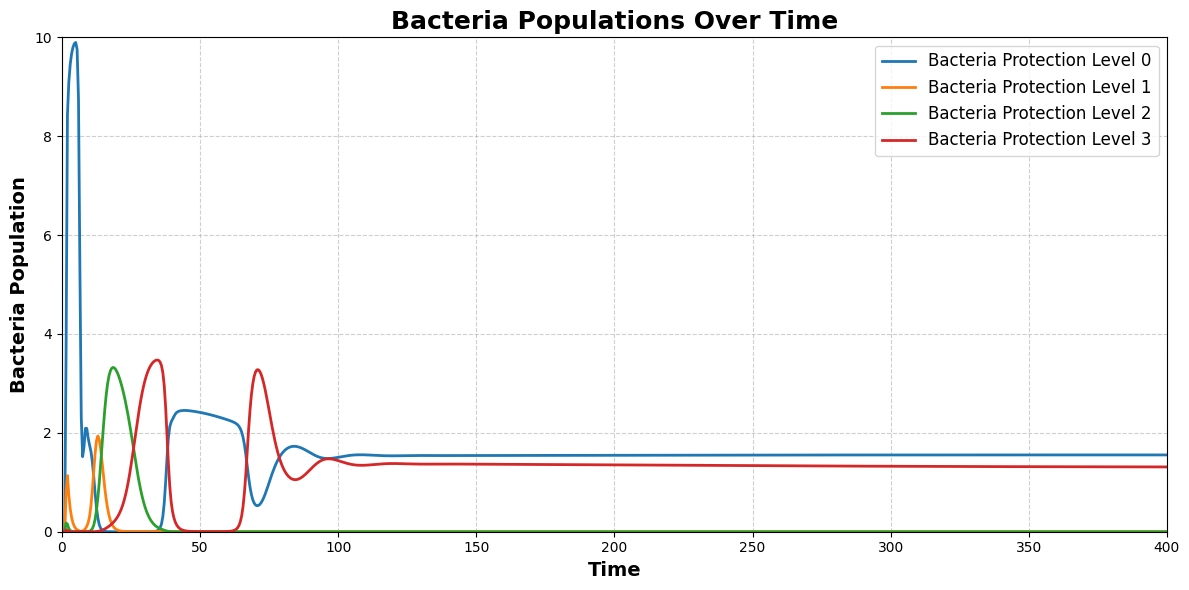

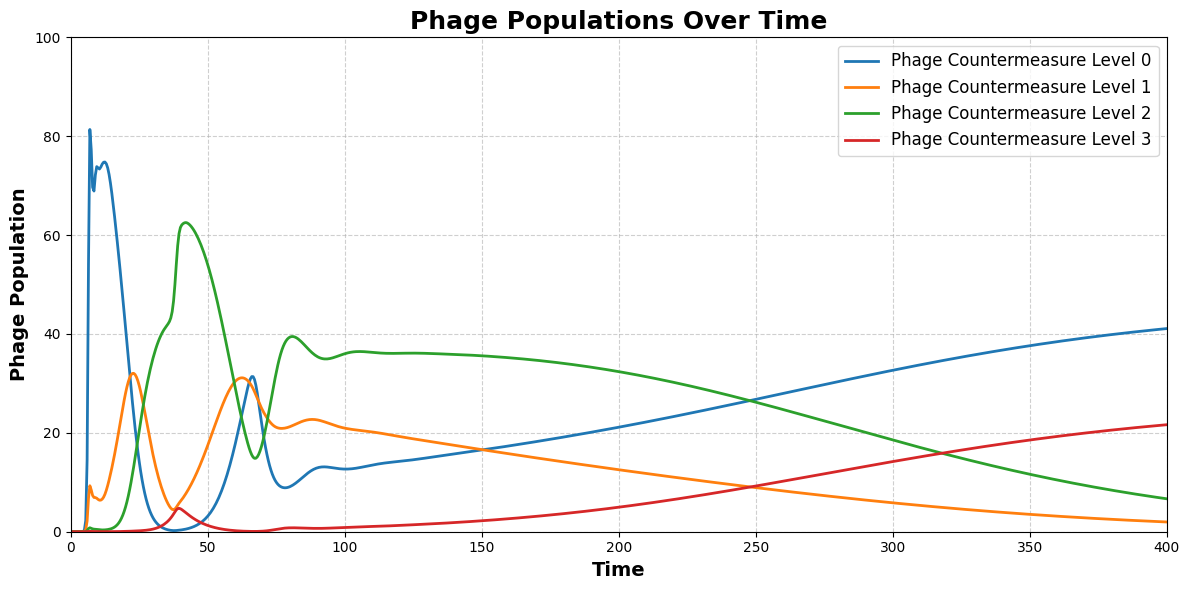

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameter Definitions
beta0 = 10          # Maximum growth rate for bacteria
C_beta = 0.1        # Coefficient adjusting bacterial growth rate based on protection layers
K = 1               # Environmental carrying capacity for bacteria
alpha0 = 0.1        # Base attack rate by phages on bacteria
C_alpha = 0.3       # Coefficient adjusting attack rate based on bacterial protection
chi0 = 5            # Maximum growth rate for phages
C_chi = 0.1         # Coefficient adjusting phage growth rate based on countermeasures
delta = 1           # Mortality rate of phages
Bseed = 2e-6        # Initial bacterial population
Pseed = 2e-6        # Initial phage population

# Maximum number of protection layers
max_layers = 4

# Function to calculate growth rate for bacteria considering protection layers
def beta_i(layers):
    """
    Calculates the growth rate of bacteria considering the protection layers.
    """
    return beta0 * (1 - C_beta * layers)

# Function to calculate growth rate for phages considering countermeasures
def chi_j(layers):
    """
    Calculates the growth rate of phages considering the countermeasures.
    """
    return chi0 * (1 - C_chi * layers)

# Function to calculate the attack rate between bacteria and phages
def alpha_ij(b_layers, p_layers):
    """
    Calculates the attack rate between a bacterial strain and a phage strain,
    adjusting for their protection and countermeasures.
    """
    return alpha0 * (1 - C_alpha)**(max(0, b_layers - p_layers))

# Define the system of ODEs for bacterial and phage population dynamics
def equations(y, t):
    """
    Defines the ODE system for the interaction between bacteria and phages.
    """
    B = y[:max_layers]  # Bacterial population (one per protection level)
    P = y[max_layers:]  # Phage population (one per protection level)

    dBdt = np.zeros(max_layers)  # Derivative of bacterial population
    dPdt = np.zeros(max_layers)  # Derivative of phage population

    # Bacterial population dynamics, affected by protection layers and phage attacks
    for i in range(max_layers):
        dBdt[i] = B[i] * (beta_i(i) - np.sum(B) / K -
                          np.sum([alpha_ij(i, j) * P[j] for j in range(max_layers)]))

    # Phage population dynamics, affected by countermeasures and bacterial population
    for j in range(max_layers):
        dPdt[j] = P[j] * (chi_j(j) * np.sum([alpha_ij(i, j) * B[i] for i in range(max_layers)]) - delta)

    return np.concatenate((dBdt, dPdt))

# Initial conditions for bacterial and phage populations
B0 = np.full(max_layers, Bseed)  # Initial bacterial population for each protection level
P0 = np.full(max_layers, Pseed)  # Initial phage population for each countermeasure level
y0 = np.concatenate((B0, P0))    # Combine initial populations

# Time points for simulation
t = np.linspace(0, 400, 800)

# Solve the system of ODEs using odeint
solution = odeint(equations, y0, t)

# Plot Bacteria Populations Over Time
plt.figure(figsize=(12, 6))
for i in range(max_layers):
    plt.plot(t, solution[:, i], label=f'Bacteria Protection Level {i}', linewidth=2)

plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Bacteria Population', fontsize=14, fontweight='bold')
plt.ylim(0, 10)  # Y-axis limits for bacteria
plt.xlim(0, 400)  # X-axis limits for time
plt.title('Bacteria Populations Over Time', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)  # Display legend
plt.tight_layout()
plt.show()

# Plot Phage Populations Over Time
plt.figure(figsize=(12, 6))
for j in range(max_layers):
    plt.plot(t, solution[:, max_layers + j], label=f'Phage Countermeasure Level {j}', linewidth=2)

plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Phage Population', fontsize=14, fontweight='bold')
plt.ylim(0, 100)  # Y-axis limits for phages
plt.xlim(0, 400)  # X-axis limits for time
plt.title('Phage Populations Over Time', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)  # Display legend
plt.tight_layout()
plt.show()
